# CNN example

Some code to show how the CNN finds ripples.

In [6]:
%%capture anaconda
%%bash
cd

MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.10.3-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [8]:
%%capture install
%%bash
git clone https://github.com/RoyVII/cnn-ripple.git
cd /content/cnn-ripple
conda env create -n cnnrippleenv -f environment.yml
conda activate cnnrippleenv

In [33]:
# Imports
import sys
import numpy as np

%cd /content/cnn-ripple/src/notebooks

sys.path.insert(1, '/content/cnn-ripple/src/cnn/')

/content/cnn-ripple/src/notebooks


In [26]:
ls

cnn-example.ipynb


## Download data

Downloads data from a Figshare repository. Example data can be found with articles IDs:
- [Thy7_2020-11-11_16-05-00](https://figshare.com/articles/dataset/Thy7_2020-11-11_16-05-00/14960085): 14960085
- [Dlx1_2021-02-12_12-46-54](https://figshare.com/articles/dataset/Dlx1_2021-02-12_12-46-54/14959449): 14959449

*If you have your own data you can skip this step.*

In [34]:
import os
sys.path.insert(1, '/content/cnn-ripple/figshare')
from figshare import Figshare

fshare = Figshare()

article_id = 14960085 # This is the ID of the data repository

datapath = "figshare_%d"%(article_id)

if os.path.isdir(datapath):
    print("Data already exists. Moving on.")
else:
    print("Downloading data... Please wait")
    fshare.retrieve_files_from_article(article_id)
    print("Data downloaded!")

['', '/content/cnn-ripple/src/cnn/', '../../figshare', '../../figshare', '../../figshare', '../../figshare', '../cnn/', '../cnn/', '../cnn/', '../../figshare', '../cnn/', '../cnn/', '../cnn/', '../cnn/', '../cnn/', '../../figshare', '../cnn/', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']
Data downloaded!


## Load data

Loads data from the path specified in *datapath*. 

If you are using **your own data** please replace this code with your own methods to load it. By the end of this cell, loaded data must comply with the following conditions:
- It has to be a 2D numpy matrix (numpy.darray) with dimensions **(Number of samples x Number of channels)**.
- Number of channels has to be 8 (corresponding to a shank).
- The variable containing the loaded data must be named **loaded_data**.
- Data sampling rate must be saved in a variable named **fs** (in Hz).

In [35]:
'''''''''''''''''
Load data from the figshare files
'''''''''''''''''

from load_data import load_data

shank = 1

# Load data
print("Loading data...", end=" ")
loaded_data, fs = load_data(path=datapath, shank=shank)
print("Done!")

print("Shape of loaded data: ", np.shape(loaded_data))

Loading data... Done!
Shape of loaded data:  (22326272, 8)


In [ ]:
'''''''''''''''''
If you have your 
own data use this 
cell to load it
'''''''''''''''''

Loaded data will be downsampled to **1250 Hz** and then normalized using **z-score** by channels. Afterwards, it will separated into **12.8 ms** windows that will be the input for the CNN. By default, these windows will have an **overlapping of 6.4 ms** between them. Overlapping can be avoided by setting the *overlapping* variable to *False*.

In [36]:
from load_data import z_score_normalization, downsample_data
# Downsample data
downsampled_fs = 1250
print("Downsampling data from %d Hz to %d Hz..."%(fs, downsampled_fs), end=" ")
data = downsample_data(loaded_data, fs, downsampled_fs)
print("Done!")

# Normalize it with z-score
print("Normalizing data...", end=" ")
data = z_score_normalization(data)
print("Done!")

print("Shape of loaded data after downsampling and z-score: ", np.shape(data))

Downsampling data from 30000 Hz to 1250 Hz... Done!
Normalizing data... Done!
Shape of loaded data after downsampling and z-score:  (930261, 8)


In [37]:
overlapping = True
window_size = 0.0128

print("Generating windows...", end=" ")
if overlapping:
    from load_data import generate_overlapping_windows
    
    stride = 0.0064

    # Separate the data into 12.8ms windows with 6.4ms overlapping
    X = generate_overlapping_windows(data, window_size, stride, downsampled_fs)
else:
    stride = window_size
    X = np.expand_dims(data, 0)
print("Done!")

Generating windows... Done!


## Load trained CNN model

In [38]:
import tensorflow.keras.backend as K
import tensorflow.keras as kr

print("Loading CNN model...", end=" ")
optimizer = kr.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model = kr.models.load_model("../../model", compile=False)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

print("Done!")

Loading CNN model... WARNING:tensorflow:SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
Done!


## Detecting ripples with CNN model

The CNN will make a prediction for every window. This consists in a **number between 0 and 1**, representing the **probability** of a ripple being in that window according to the CNN.

In [39]:
print("Detecting ripples...", end=" ")
predictions = model.predict(X, verbose=True)
print("Done!")

3634/3634 [==============================] - 7s 2ms/step
Done!


### Get detected ripples and times

Gets the detected ripples times, both in seconds and in indexes of the downsampled data array. The resulting times are a 2D numpy array with dimensions **(Number of detections x 2)**, having the starting and ending times for each detection.

It will consider as a ripple detection all those windows whose associated probability is **over a given threshold**. This threshold can be changed by the user and can vary from one session to another. With a high threshold it will consider only those events that the CNN strongly believes to be ripples, but some other may be left aside. A lower threshold will capture more events, but maybe some of them will not be really ripples.

In [40]:
from format_predictions import get_predictions_indexes

# This threshold can be changed
threshold = 0.7

print("Getting detected ripples indexes and times...", end=" ")
pred_indexes = get_predictions_indexes(data, predictions, window_size=window_size, stride=stride, fs=downsampled_fs, threshold=threshold)

pred_times = pred_indexes / downsampled_fs
print("Done!")

Getting detected ripples indexes and times... Done!


### Plot ripple detections

This is an interactive plot of the loaded data, where detected ripples are shown in blue. Data is displayed in chunks of 1 seconds and you can **move forward, backwards or jump to an specific second** using the control bar at the bottom.

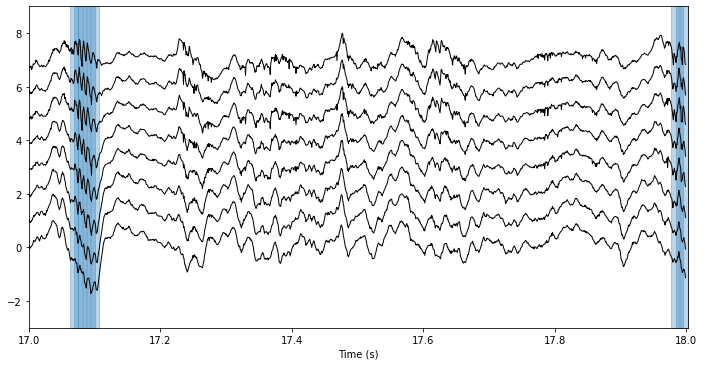

In [62]:
import matplotlib.pyplot as plt

k = 17
data_size = data.shape[0]
data_dur = data_size / downsampled_fs
times = np.arange(data_size) / downsampled_fs

ini_idx = int(k * downsampled_fs)
end_idx = np.minimum(int((k+1) * downsampled_fs), data_size-1)


pos_mat = list(range(data.shape[1]-1, -1, -1)) * np.ones((end_idx-ini_idx, data.shape[1]))

fig = plt.figure(figsize=(9.75,5))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim(-3, 9)
ax.margins(x=0)
plt.tight_layout()
plt.xlabel("Time (s)")


lines = ax.plot(times[ini_idx:end_idx], data[ini_idx:end_idx, :]*1/np.max(data[ini_idx:end_idx, :], axis=0) + pos_mat, color='k', linewidth=1)

fills = []
for pred in pred_indexes:
    if (pred[0] >= ini_idx and pred[0] <= end_idx) or (pred[1] >= ini_idx and pred[1] <= end_idx):
        rip_ini = (pred[0]) / downsampled_fs
        rip_end = (pred[1]) / downsampled_fs
        fill = ax.fill_between([rip_ini, rip_end], [-3, -3], [9, 9], color="tab:blue", alpha=0.3)
        fills.append(fill)

plt.show()